In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#double-64bit-precision
# again, this only works on startup!
from jax.config import config
config.update("jax_enable_x64", True)

from util   import *
from basics import *
from simulate_data import *
from estimators    import *
from config import *
from scipy.special import *
configure_pylab()   

# Shadow all pylab functions and numpy with the Jax versions
# Keep numpy around as np0 for easier RNG, array assignments
import jax
import jax.numpy as np
import numpy.random as npr
from jax               import jit, grad, vmap
from jax.config        import config
from jax.scipy.special import logsumexp
from jax.numpy         import *
from jax import jacfwd, jacrev
from jax import lax
from jax.numpy.fft import *
from jax.numpy.linalg import *
fori = lax.fori_loop
def hess(f,inparam):
    return jacfwd(jacrev(f,inparam),inparam)
def hvp(f, x, v):
    return grad(lambda x: vdot(grad(f)(x), v))(x)
import numpy as np0

# redefine these with Jax env so it can be traced
def conv(x,K):
    return real(ifft2(fft2(x.reshape(L,L))*K))
def slog(x,minrate = 1e-10):
    return log(maximum(minrate,x))
def sexp(x,bound = 10):
    return exp(clip(x,-bound,bound))
from numpy.linalg import cholesky as chol
def logdetpsd(Σ):
    return 2*sum(slog(diag(chol(Σ))))
def vec(X):
    return X.ravel()

## Simulate grid cell data 

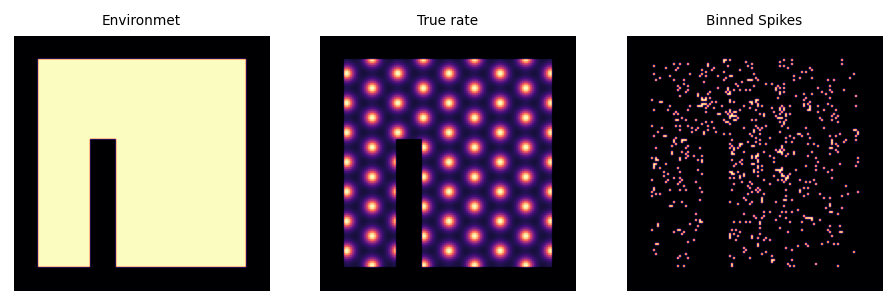

In [10]:
L = 128  # Grid size
P = L/10 # Grid spacing
α = 0.5  # Grid "sharpness"
μ = 1500/L**2 # Mean firing rate (spikes per sample)
mask,λ0,λ0_bg,N,K = simulate_data(L,P,α,μ)
subplot(131); showim(mask,'Environmet')
subplot(132); showim(λ0,'True rate')
subplot(133); showim(K,'Binned Spikes');

fgσ  = P/pi
bgσ  = fgσ*5

# Bessel function
coords = zgrid(L)
kernR  = j0(fftshift(abs(coords*2*pi/P)))
window = hanning(L)
window = outer(window,window)
kernR  = kernR*fftshift(window)
fftkr  = fftshift(real(ifft2(kernR)))

# Restrict kernel to local neighborhood and normalize
k3     = jn_zeros(0,3)[-1]
fwin   = abs(coords)<P*k3/(2*pi)
kern0  = kernR*fftshift(fwin)
kern0  = blur(kern0,P/pi)
kern0  = kern0/np.max(kern0)

# Prepare data
lλb  = slog(kdeλ(N,K,bgσ))     # Log background (initial estimate)
lλf  = slog(kdeλ(N,K,fgσ))-lλb # Log foreground (initial estimate)
n    = N.ravel()               # Number of visits per bin
y    = nan_to_num(K/N).ravel() # Lumped pseudo-observerations
lλb  = lλb.ravel()             # Background offsets

## Variational Bayes: Local approximation 

We consider an approximate posterior covariance of the form

\begin{equation}\begin{aligned}
\boldsymbol\Sigma &\approx \mathbf A^\top \operatorname{diag}[\mathbf v] \mathbf A,
\end{aligned}\end{equation}

where $\mathbf A$ is fixed and $\mathbf v$ is to be optimized. Neglecting terms that do not depend on $\mathbf v$, the loss to be minimized is:

\begin{equation}\begin{aligned}
\mathcal L(\mathbf v)&=\mathbf n^\top \exp\left(\boldsymbol\mu + \tfrac 1 2 \operatorname{diag}[\boldsymbol\Sigma]\right)+ \tfrac 1 2 \left \{ \operatorname{tr}[\boldsymbol\Sigma_0^{-1}\boldsymbol\Sigma] - \ln|\boldsymbol\Sigma|\right\}
\end{aligned}\end{equation}

In this case, the log-determinant of the posterior covariance reduces to $\ln|\boldsymbol\Sigma| = \mathbb 1^\top \ln(\mathbf v) + \text{constant}$. The trace $\operatorname{tr}[\boldsymbol\Sigma_0^{-1}\boldsymbol\Sigma] = \operatorname{tr}[\boldsymbol\Sigma_0^{-1}\mathbf A^\top \operatorname{diag}[\mathbf v]\, \mathbf A]$ can be written as $\operatorname{diag}[\mathbf A\boldsymbol\Sigma_0^{-1}\mathbf A^\top]^\top \mathbf v$. Computing the expected rate $\langle\boldsymbol\lambda\rangle$ requires $\operatorname{diag}[\mathbf A^\top \operatorname{diag}[\mathbf v] \,\mathbf A]$, which can be written as $\mathbf G\mathbf v$ where $\mathbf G = \mathbf A \circ \mathbf A^\top$. 

\begin{equation}\begin{aligned}
\mathcal L(\mathbf v)
&=
\mathbf n^\top \exp\left(\boldsymbol\mu + \tfrac12\mathbf G\mathbf v\right)
+ \tfrac 1 2 \left \{ \operatorname{diag}[\mathbf A\boldsymbol\Sigma_0^{-1}\mathbf A^\top]^\top \mathbf v  - \mathbb 1^\top \ln(\mathbf v)
\right\}
\end{aligned}\end{equation}

The gradient and Hessian of this loss function in $\mathbf v$ are : 

\begin{equation}\begin{aligned}
%%%% GRADIENT IN v
\operatorname{\nabla}_{\mathbf v}
\mathcal L &=\tfrac 1 2 \left\{
\mathbf G^\top (\mathbf n \circ \langle\boldsymbol\lambda\rangle)
+ \operatorname{diag}[\mathbf A \boldsymbol\Sigma_0^{-1} \mathbf A^\top]
- \tfrac 1 {\mathbf v}
\right\}
\\
%%%% HESSIAN IN v
\operatorname{H}_{\mathbf v}
\mathcal L &=\tfrac 1 2 \left\{
\tfrac 1 2 
\mathbf G \operatorname{diag}[\mathbf n \circ \langle\boldsymbol\lambda\rangle] \, \mathbf G 
+ \operatorname{diag}\left[\tfrac 1 {\mathbf v^2}\right]
\right\}
\end{aligned}\end{equation}

This follows from the usual matrix and scalar derivatives, with the exception of the term $\mathbf n^\top \langle\boldsymbol\lambda\rangle$. These can be obtained by considering the derivative with respect to single elements of $\mathbf v$ (note: $\mathbf G$ is symmetric): 

\begin{equation}\begin{aligned}
\tfrac{d}{dv_j} \mathbf n^\top\langle\boldsymbol\lambda\rangle 
&=  \mathbf n^\top
\tfrac{d}{dv_j}  \langle\boldsymbol\lambda\rangle 
\\
&=  \mathbf n^\top
\tfrac{d}{dv_j} \exp\left(\boldsymbol\mu + \tfrac12\mathbf G\mathbf v\right)
\\
&= \tfrac{d}{dv_j} \sum_k
n_k \exp\left[\mu_k + \tfrac12(\mathbf G\mathbf v)_k\right]
\\
&= \sum_k
n_k \left[
\langle\lambda_k\rangle
\cdot \tfrac12 \tfrac{d}{dv_j} (\mathbf G\mathbf v)_k
\right]
\\
&= 
\tfrac12 \sum_k
 n_k 
\langle\boldsymbol\lambda_k\rangle
\textstyle \mathbf G_{kj} 
\\
&= 
\tfrac12 \left[ \mathbf G^\top(\mathbf n\circ\langle\boldsymbol\lambda\rangle) \right]_j
\\\\
\tfrac{d^2}{dv_iv_j} \mathbf n^\top\langle\boldsymbol\lambda\rangle 
&= 
\tfrac12 \left[ \sum_k n_k \tfrac{d}{dv_i} \langle\boldsymbol\lambda_k\rangle\textstyle \mathbf G_{kj} \right]_j
\\
&= 
\tfrac14 \left[ \sum_k n_k 
\langle\boldsymbol\lambda_k\rangle
\textstyle \mathbf G_{jk} 
\textstyle \mathbf G_{ki} 
\right]_j
\\
&= 
\tfrac 1 4 \left[\mathbf G \operatorname{diag}[\mathbf n\circ \langle\boldsymbol\lambda\rangle] \, 
\mathbf G
\right]_{ij}
\end{aligned}\end{equation}

## Analytic gradients

loss=1.046370e+08
iteration 0 ε=6.769130e-01 mintol=1.000000e-02 loss=-2.222250e+03
iteration 1 ε=2.912111e-02 mintol=1.000000e-02 loss=-2.362817e+04
iteration 2 ε=4.086604e-01 mintol=1.000000e-02 loss=-2.536003e+04
iteration 3 ε=1.268996e-02 mintol=5.000000e-03 loss=-2.626874e+04
iteration 4 ε=3.408356e-02 mintol=5.000000e-03 loss=-2.752897e+04
iteration 5 ε=6.868563e-01 mintol=2.500000e-03 loss=-2.810301e+04
iteration 6 ε=6.540454e-02 mintol=1.250000e-03 loss=-2.817278e+04
iteration 7 ε=3.329414e-02 mintol=1.250000e-03 loss=-2.819084e+04
iteration 8 ε=1.446501e-02 mintol=1.250000e-03 loss=-2.819869e+04
iteration 9 ε=3.555455e-03 mintol=1.250000e-03 loss=-2.819990e+04
iteration 10 ε=2.889362e-03 mintol=1.250000e-03 loss=-2.820039e+04
iteration 11 ε=3.105395e-03 mintol=1.250000e-03 loss=-2.820050e+04
iteration 12 ε=7.620049e-04 mintol=6.250000e-04 loss=-2.820055e+04
iteration 13 ε=2.985007e-04 mintol=6.250000e-04 loss=-2.820056e+04
iteration 14 ε=1.523301e-04 mintol=6.250000e-04 loss=-

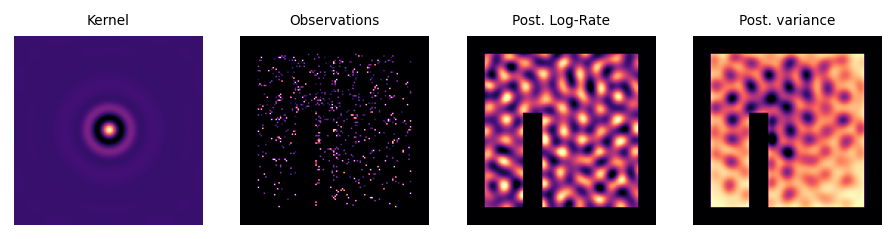

In [9]:
# Precompute variables; Passed as globals to jac/hess
kern = kern0*zerolag(radial_acorr(lλf,mask))
kern = repair_small_eigenvalues(kern,1e-5)
knft = np0.array(real(fft2(kern)))
knft[0,0] += 1e6
kift = 1.0/knft

# Kernel for variational posterior variance
vkern0 = blurkernel(L,fgσ)
vkern  = outer(vkern0,vkern0)
vkern  = repair_small_eigenvalues(vkern,1e-12)
vkern  = vkern/sum(vkern)
vkft   = real(fft2(vkern))
vift   = 1.0/vkft

# Convolution operators
G  = cop(vkft)
Gi = cop(vift)
M  = cop(knft)
Ki = cop(kift)
    
# This term enters into the variance optimization
k2      = kift*vkft
diagΛ0  = mean(kift)*ones(L*L)
diagAΛA = mean(k2)*ones(L*L)

def loss(μ,v):
    v  = np.maximum(1e-9,abs(v))
    dv  = G(v)
    λ   = sexp(μ+lλb.ravel()+0.5*dv)
    ε   = λ - μ*y.ravel()
    μΛμ = μ @ conv(μ, kift).ravel()
    return n@ε + 0.5*(sum(slog(knft)) + diagAΛA@v + μΛμ - sum(slog(v)))

tic('elapsed')
# Use firing rate as an initial guess for posterior variance
# Incorporate this as a variance correction 
v = 1/diagΛ0
μ = lλf.ravel()
mintol = 1e-2
ε = inf
l = inf
print('loss=%e'%loss(μ,v))
for iteration in range(100):
    for i in range(5):
        dv = G@v
        nλ = n*sexp(μ+vec(lλb)+dv/2)
        Hμ = Ki + diagop(nλ)
        Jμ = Ki@μ + nλ - n*vec(y)
        Δμ = -minres(Hμ,Jμ,tol=mintol,M=M)[0]
        μ+= Δμ
    εμ = np.mean(abs(Δμ)/abs(μ))
    for i in range(5):
        dv = G@v
        nλ = n*sexp(μ+vec(lλb)+dv/2)
        Jv = 0.5*(G@nλ+diagAΛA-1/dv)
        Hv = 0.25*G@diagop(nλ)@G + 0.5*diagop(dv**-2)
        Δv = -minres(Hv,Jv,tol=mintol)[0]
        v+= Δv
        v = np.maximum(1e-5,v)
    εv = np.mean(abs(Δv)/abs(v))
    
    oldε = ε
    ε = mean(array([εμ,εv]))
    oldl = l
    l = loss(μ,v)
    print('iteration',iteration,'ε=%e'%ε,'mintol=%e'%mintol,'loss=%e'%l)
    if oldl<l:
        print('Loss increasing, that\'s bad')
        mintol *= 0.5
    if ε<1e-5:
        print('Converged')
        break
    if ε>oldε:
        mintol *= 0.5
tic('elapsed')
        
subplot(141); showkn(kern,'Kernel');
subplot(142); showim(np0.array(y),'Observations');
subplot(143); showim(μ,'Post. Log-Rate',mask=mask);
subplot(144); showim(G(v),'Post. variance',mask=mask);

μ_=μ
v_=v

# Using Jax 

loss=5.734848e+03
iteration 0 ε=2.526352e-01 mintol=1.000000e-02 loss=2.406735e+01
iteration 1 ε=1.958203e-01 mintol=1.000000e-02 loss=-1.581011e-01
iteration 2 ε=5.118231e-01 mintol=1.000000e-02 loss=2.342833e+01
Loss increasing, that's bad
iteration 3 ε=2.841081e-01 mintol=2.500000e-03 loss=-9.308460e-01
iteration 4 ε=1.157155e-01 mintol=2.500000e-03 loss=-1.474552e+00
iteration 5 ε=2.431301e-02 mintol=2.500000e-03 loss=-1.574152e+00
iteration 6 ε=8.048238e-01 mintol=2.500000e-03 loss=-1.676581e+00
iteration 7 ε=6.816361e-02 mintol=1.250000e-03 loss=-1.704880e+00
iteration 8 ε=1.698739e-01 mintol=1.250000e-03 loss=-1.716098e+00
iteration 9 ε=2.736128e-01 mintol=6.250000e-04 loss=-1.719581e+00
iteration 10 ε=1.601118e-02 mintol=3.125000e-04 loss=-1.721557e+00
iteration 11 ε=9.470834e-03 mintol=3.125000e-04 loss=-1.721878e+00
iteration 12 ε=4.025106e-03 mintol=3.125000e-04 loss=-1.721956e+00
iteration 13 ε=2.760148e-03 mintol=3.125000e-04 loss=-1.721996e+00
iteration 14 ε=1.444751e-03 

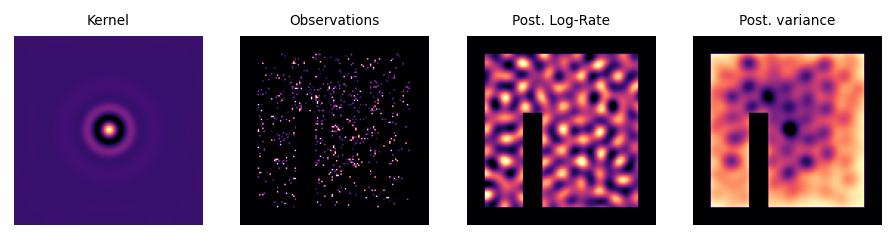

In [411]:
@jit
def loss(μ,v):
    v   = maximum(1e-9,abs(v))
    dv  = vec(conv(v,vkft))
    λ   = sexp(μ+vec(lλb)+0.5*dv)
    ε   = λ - μ*vec(y)
    μΛμ = μ @ vec(conv(μ,kift))
    return (n@ε + 0.5*(sum(slog(knft)) + diagAΛA@v + μΛμ - sum(slog(v))))/L**2
Jμ = jit(grad(loss,0))
Jv = jit(grad(loss,1))

tic()
v = 1/diagΛ0
μ = lλf.ravel()
mintol = 1e-2
ε = inf
l = inf
print('loss=%e'%loss(μ,v))
for iteration in range(100):
    for i in range(5):
        Hμ = op(L*L, lambda V: grad(lambda μ: vdot(Jμ(μ,v), V))(μ))
        Δμ = -minres(Hμ,Jμ(μ,v),tol=mintol,M=M)[0]
        μ+= Δμ
    εμ = np.mean(abs(Δμ)/abs(μ))
    for i in range(5):
        Hv = op(L*L, lambda V: grad(lambda v: vdot(Jv(μ,v), V))(v))
        Δv = -minres(Hv,Jv(μ,v),tol=mintol)[0]
        v+= Δv
        v = np.maximum(1e-5,v)
    εv = np.mean(abs(Δv)/abs(v))
    
    oldε = ε
    ε = mean(array([εμ,εv]))
    oldl = l
    l = loss(μ,v)
    print('iteration',iteration,'ε=%e'%ε,'mintol=%e'%mintol,'loss=%e'%l)
    if oldl<l:
        print('Loss increasing, that\'s bad')
        mintol *= 0.5
    if ε<1e-5:
        print('Converged')
        break
    if ε>oldε:
        mintol *= 0.5
tic('elapsed')  
    
subplot(141); showkn(kern,'Kernel');
subplot(142); showim(np0.array(y),'Observations');
subplot(143); showim(μ,'Post. Log-Rate',mask=mask);
subplot(144); showim(G(v),'Post. variance',mask=mask);

print(mean(abs(μ_-μ)/abs(μ_)))
print(mean(abs(v_-v)/abs(v_)))